# Summarization

In this chapter, we are going to build our own encoder-decoder model to condense dialogues between several people into a crisp summary.

## The CNN/DailyMail Dataset

The CNN/DailyMail dataset consists of around 300,000 pairs of news articles and their corresponding summaries, composed from the bullet points that CNN and the DailyMail attach to their articles.

The summaries are abstractive instead of extractive, meaning that it doesn't necessarily extract exact sentences from the original text.

In [5]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", "3.0.0")
print(f"Features: {dataset['train'].column_names}")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Features: ['article', 'highlights', 'id']


In [10]:
sample = dataset["train"][1]
print(f"Article (excerpt of 500 characters, total length: {len(sample['article'])}):")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])

Article (excerpt of 500 characters, total length: 4051):
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


## Text Summarization Pipeline

let's restrict the input text to 2,000 characters to have the same input for all models and thus make the outputs more comparable:

In [13]:
sample_text = dataset["train"][1]["article"][:2000]

# We'll collect the generated summaries of each model in a dictionary
summaries = {}

Conventionally, sentences are separated by a newline when doing summarization. To help us with that, we'll use NLTK:

In [15]:
import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")
string = "The U.S. are a country. The U.N. is an organization."
sent_tokenize(string)

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alexandre.dias/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['The U.S. are a country.', 'The U.N. is an organization.']

### Summarization Baseline

Our baseline will be a model that takes the first three sentences of an article.

In [16]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

summaries["baseline"] = three_sentence_summary(sample_text)

### GPT-2

GPT-2 can be used for text summarization by simply appending "TL;DR" at the end of the input text

In [19]:
sample_text

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and less likely to foll

In [20]:
from transformers import pipeline, set_seed

set_seed(42)
pipe = pipeline("text-generation", model="gpt2")
gpt2_query = sample_text + "\nTL;DR:\n"

pipe_out = pipe(gpt2_query, max_length=512, clean_up_tokenization_spaces=True)

summaries["gpt2"] = "\n".join(
    sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :])
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


### T5

the T5 developers performed a comprehensive study of transfer learning in NLP and found they could create a universal transformer architecture by formulating all tasks as text-totext tasks.

In [22]:
pipe = pipeline("summarization", model="t5-small")
pipe_out = pipe(sample_text)
summaries["t5"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

### BART

BART also uses an encoder-decoder architecture and is trained to reconstruct corrupted inputs. It combines the pretraining schemes of BERT and GPT-2.

In [44]:
pipe = pipeline("summarization", model="facebook/bart-base")
pipe_out = pipe(sample_text)
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

### PEGASUS

Like BART, PEGASUS is an encoder-decoder transformer. Its pretraining objective is to predict masked sentences in multisentence texts.

In [25]:
# the model is too big (2.28 GB)
# pipe = pipeline("summarization", model="google/pegasus-cnn_dailymail")
# pipe_out = pipe(sample_text)
# summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

## Comparing Different Summaries

In [26]:
print("GROUND TRUTH")
print(dataset["train"][1]["highlights"])
print("")

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])
    print("")

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .

BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."

GPT2

The prison in jail that serves the mentally ill is a mental health facility with 12,000 inmates.
It was founded by psychiatrist Dr. Daniel M. Dufour, who was born in New Orleans by his parents when he was 12.
The pris

## Measuring the Quality of Generated Text

Two of the most common metrics used to evaluate generated text are BLEU and ROUGE. Let’s take a look at how they’re defined.

### BLEU

In [29]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for sacrebleu contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/sacrebleu/sacrebleu.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [30]:
import pandas as pd
import numpy as np

bleu_metric.add(prediction="the the the the the the", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[6, 5, 4, 3]"
precisions,"[33.33, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,6
ref_len,6


In [31]:
bleu_metric.add(prediction="the cat is on mat", reference=["the cat is on the mat"])
results = bleu_metric.compute(smooth_method="floor", smooth_value=0)
results["precisions"] = [np.round(p, 2) for p in results["precisions"]]

pd.DataFrame.from_dict(results, orient="index", columns=["Value"])

,Value
score,57.893007
counts,"[5, 3, 2, 1]"
totals,"[5, 4, 3, 2]"
precisions,"[100.0, 75.0, 66.67, 50.0]"
bp,0.818731
sys_len,5
ref_len,6


The BLEU score is widely used for evaluating text, especially in machine translation, since precise translations are usually favored over translations that include all possible and appropriate words.

There are other applications, such as summarization, where the situation is different. There, we want all the important information in the generated text, so we favor high recall. This is where the ROUGE score is usually used

### ROUGE

The ROUGE score was specifically developed for applications like summarization where high recall is more important than just precision. Its final version is modified to appear more with a F1 score.

In [33]:
rouge_metric = load_metric("rouge")

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [34]:
reference = dataset["train"][1]["highlights"]
records = []
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

for model_name in summaries:
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    records.append(rouge_dict)
    
pd.DataFrame.from_records(records, index=summaries.keys())

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.252252,0.018349,0.144144,0.234234
t5,0.195652,0.022222,0.108696,0.173913
bart,0.326531,0.124138,0.176871,0.285714


## Evaluating BART on the CNN/DailyMail Dataset

In [35]:
def evaluate_summaries_baseline(dataset, metric, column_text="article", column_summary="highlights"):
    summaries = [three_sentence_summary(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    score = metric.compute()
    return score

In [36]:
test_sampled = dataset["test"].shuffle(seed=42).select(range(1000))
score = evaluate_summaries_baseline(test_sampled, rouge_metric)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict, orient="index", columns=["baseline"]).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.389276,0.171296,0.245061,0.354239


Now let's implement the same evaluation function for evaluating the BART model:

In [37]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def chunks(list_of_elements, batch_size):
    """Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]
        
        
def evaluate_summaries_bart(dataset, metric, model, tokenizer, batch_size=16, device=device, column_text="article", column_summary="highlights"):
    article_batches = list(chunks(dataset[column_text], batch_size))
    target_batches = list(chunks(dataset[column_summary], batch_size))
    
    for article_batch, target_batch in tqdm(zip(article_batches, target_batches), total=len(article_batches)):
        inputs = tokenizer(article_batch, max_length=1024, truncation=True, padding="max_length", return_tensors="pt")
        
        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                                   attention_mask=inputs["attention_mask"].to(device),
                                   length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True) for s in summaries]
        
        decoded_summaries = ["\n".join(sent_tokenize(d)) for d in decoded_summaries]
        metric.add_batch(predictions=decoded_summaries, references=target_batch)
        
    score = metric.compute()
    return score

In [38]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "facebook/bart-base"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [40]:
# score = evaluate_summaries_bart(test_sampled, rouge_metric, model, tokenizer, batch_size=8)

In [41]:
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["bart"])

## Training a Summarization Model

In [43]:
dataset_samsum = load_dataset("samsum")
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]

print(f"Split lengths: {split_lengths}")
print(f"Features: {dataset_samsum['train'].column_names}")
print("\nDialogue:")
print(dataset_samsum["test"][0]["dialogue"])
print("\nSummary:")
print(dataset_samsum["test"][0]["summary"])

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.


### Evaluating BART on SAMSum

First, let's see how bart would perform on the last example

In [45]:
pipe_out = pipe(dataset_samsum["test"][0]["dialogue"])
print("Summary:")
print("\n".join(sent_tokenize(pipe_out[0]["summary_text"])))

Summary:
Hannah: Hey, do you have Betty's number?Amanda: Lemme check it out.Hannah?Hannah.
<file_gif>What's her number?Is it her?Am Amanda: Sorry, can't find it.Is her number yours?Is your number hers?Is her phone mine?Is my number hers?
?Is it hers?Handa: He called her last time we were at the park together.Is my phone hers?
Hannah: I don't know him well.Is his number hersAmanda?Is his phone mine?
?Hannah; Don't be shy,


In [46]:
# # let's run a full evaluation on the samsum dataset
# score = evaluate_summaries_bart(dataset_samsum["test"], rouge_metric, model, tokenizer, column_text="dialogue", column_summary="summary", batch_size=8)
# rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
# pd.DataFrame(rouge_dict, index=["pegasus"])

### Fine-Tuning BART

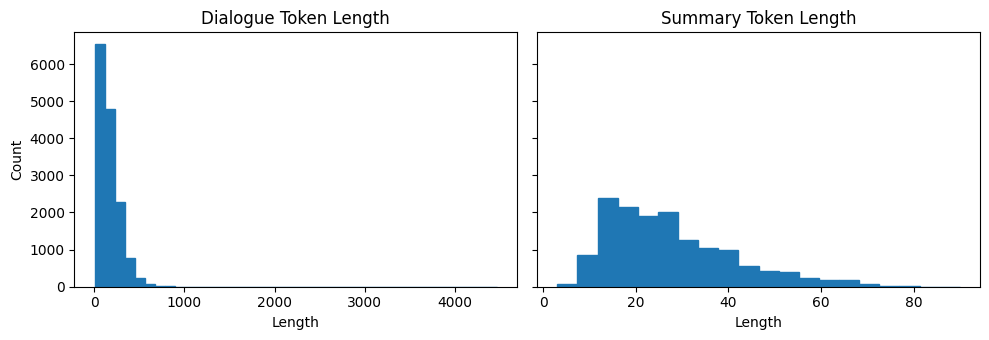

In [48]:
import matplotlib.pyplot as plt

d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=40, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

We see that most dialogues are much shorter than the CNN/DailyMail articles, with 100–200 tokens per dialogue. Similarly, the summaries are much shorter, with around 20–40 tokens (the average length of a tweet).

Now, we are going to tokenize the dataset.

In [49]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024, truncation=True)
    
    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128, truncation=True)
        
    return {"input_ids": input_encodings["input_ids"],
            "attention_mask": input_encodings["attention_mask"],
            "labels": target_encodings["input_ids"]}
    
dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:3946: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [50]:
dataset_samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

Now, we need to create the data collator. This function is called in the Trainer just before the batch is fed through the model. In most cases we can use the default colla‐ tor, which collects all the tensors from the batch and simply stacks them. For the summarization task we need to not only stack the inputs but also prepare the targets on the decoder side.

In [51]:
from transformers import DataCollatorForSeq2Seq
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [52]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(
    output_dir='bart-samsum', 
    num_train_epochs=1, 
    warmup_steps=500,
    per_device_train_batch_size=1, 
    per_device_eval_batch_size=1,
    weight_decay=0.01, 
    logging_steps=10, 
    push_to_hub=False,
    evaluation_strategy='steps', 
    eval_steps=500, 
    save_steps=1e6,
    gradient_accumulation_steps=16)

/Users/alexandre.dias/.pyenv/versions/3.9.13/envs/nlp/lib/python3.9/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  tokenizer=tokenizer, 
                  data_collator=seq2seq_data_collator, 
                  train_dataset=dataset_samsum_pt["train"], 
                  eval_dataset=dataset_samsum_pt["validation"])

In [ ]:
trainer.train()

In [ ]:
score = evaluate_summaries_bart(dataset_samsum["test"], 
                                rouge_metric, 
                                trainer.model, 
                                tokenizer, 
                                batch_size=2, 
                                column_text="dialogue", 
                                column_summary="summary")

In [ ]:
rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame(rouge_dict, index=[f"bart-samsum"])